In [1]:
library(tidyverse)
library(cowplot)
library(e1071)
library(ggrepel)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [2]:
cars_df <- as_tibble(cars)

In [3]:
names(cars_df)

[1] "speed" "dist"

# Functions

In [4]:
model_residuals <- function(model, y, data) {
    yhat <- as.vector(predict.glm(model, data))
    resid <- y - yhat
    resid_df <- tibble(value = resid)
    resid_skew <- round(e1071::skewness(resid_df$value), 2)
    xpos <- quantile(resid)[4]
    ypos <- quantile(density(resid)$y)[4]
    resid_labels <- tibble(skew = paste0("skewness = ", resid_skew)) %>%
        mutate(xpos = xpos, ypos = ypos)
    plt <- ggplot() +
        geom_density(data = resid_df, aes(x = value)) +
        geom_label(data = resid_labels, aes(x = xpos, y = ypos, label = skew))
    return(list(resid = resid, plt = plt))
}


eval_performance <- function(y, yhat) {
    res <- list()
    y_yhat_df <- tibble("y" = y, "yhat" = yhat)
    
    # Correlation accuracy
    cor_acc <- cor(as.matrix(y_yhat_df))
    res[["cor_acc"]] <- cor_acc["yhat", "y"]
    
    # Min-max accuracy
    res[["minmax_acc"]] <- mean(apply(y_yhat_df, 1, min) / apply(y_yhat_df, 1, max))
    
    # MSE
    res[["mse"]] <- mean((y_yhat_df$y - y_yhat_df$yhat) ^ 2)
    
    # Mean Absolute Percent Error
    res[["mape"]] <- mean(abs(y_yhat_df$y - y_yhat_df$yhat) / y_yhat_df$y)
    
    return(res)
}

# Exploratory plots

## Scatter plot (with line & confidence interval)

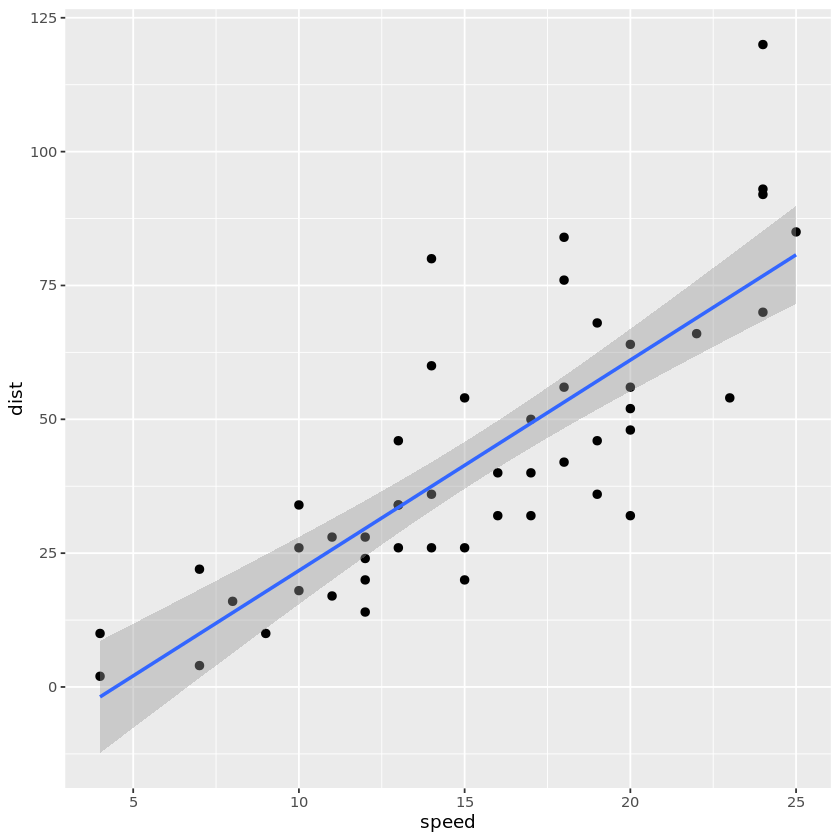

In [5]:
ggplot(cars_df) +
    aes(x = speed, y = dist) +
    geom_point(size = 2) +
    geom_smooth(method = "lm", formula = y ~ x)

## Boxplots with outliers in red

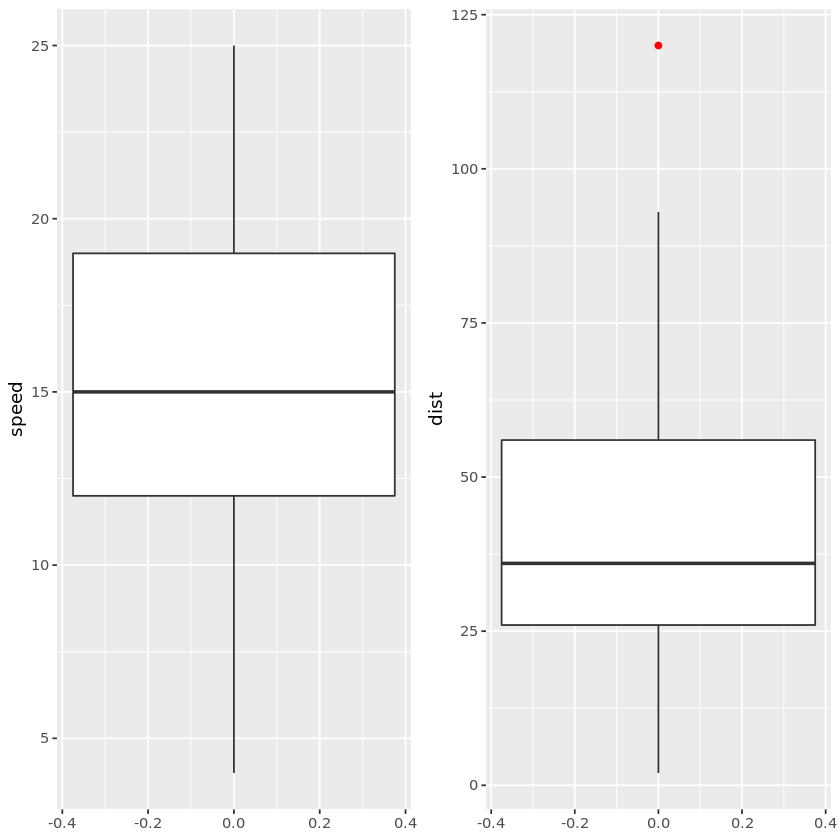

In [6]:
bp1 <- ggplot(cars_df) +
    aes(y = speed) +
    geom_boxplot(outlier.color = "red")

bp2 <- ggplot(cars_df) +
    aes(y = dist) +
    geom_boxplot(outlier.color = "red")

plot_grid(bp1, bp2, ncol = 2)

## Overlapping density plots

In [7]:
dist_skew <- round(e1071::skewness(cars_df$dist), 2)
speed_skew <- round(e1071::skewness(cars_df$speed), 2)

`summarise()` regrouping output by 'param' (override with `.groups` argument)



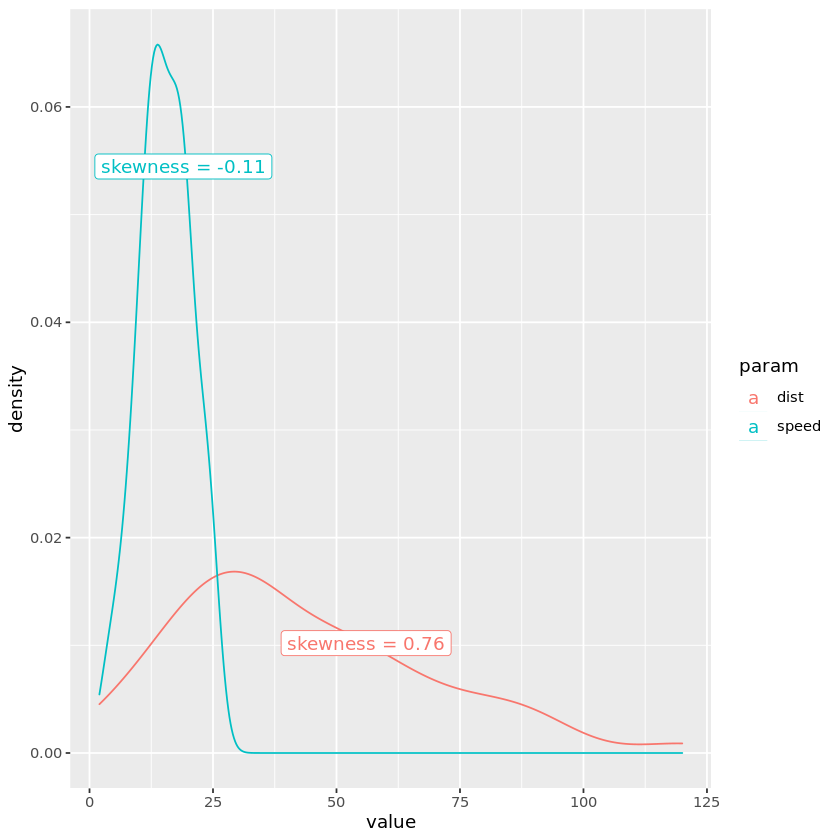

In [8]:
cars_pivot_df <- cars_df %>%
    pivot_longer(cols = c(speed, dist), names_to = "param", values_to = "value") %>%
    mutate(skew = case_when(
        param == "dist" ~ paste0("skewness = ", dist_skew),
        param == "speed" ~ paste0("skewness = ", speed_skew)
    ))

labels <- cars_pivot_df %>%
    group_by(param, skew) %>%
    summarize(xpos = quantile(value)[4], ypos = quantile(density(value)$y)[4])

ggplot() +
    geom_density(data = cars_pivot_df, aes(x = value, color = param)) +
    geom_label(data=labels, aes(x=xpos, y=ypos, label=skew, color = param))

# Correlation

In [9]:
cor(cars_df$speed, cars_df$dist)

[1] 0.8068949

# Linear model

In [10]:
lin_model <- glm(dist ~ speed, data = cars_df, family = gaussian())
null_model <- glm(dist ~ 1, data = cars_df, family = gaussian())

In [11]:
lin_model


Call:  glm(formula = dist ~ speed, family = gaussian(), data = cars_df)

Coefficients:
(Intercept)        speed  
    -17.579        3.932  

Degrees of Freedom: 49 Total (i.e. Null);  48 Residual
Null Deviance:	    32540 
Residual Deviance: 11350 	AIC: 419.2

In [12]:
model_summary <- summary(lin_model)
model_summary
resid_deviance <- model_summary$deviance
null_deviance <- model_summary$null.deviance
print(paste0("R-squared = ", round(1 - (lin_model$deviance / lin_model$null.deviance), 3)))
res_anova <- anova(lin_model, null_model, test = "F")
res_anova
print(paste0("P-value of model = ", res_anova[2, 6]))


Call:
glm(formula = dist ~ speed, family = gaussian(), data = cars_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-29.069   -9.525   -2.272    9.215   43.201  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -17.5791     6.7584  -2.601   0.0123 *  
speed         3.9324     0.4155   9.464 1.49e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 236.5317)

    Null deviance: 32539  on 49  degrees of freedom
Residual deviance: 11354  on 48  degrees of freedom
AIC: 419.16

Number of Fisher Scoring iterations: 2


[1] "R-squared = 0.651"


,Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,48,11353.52,NA,NA,NA,NA
2,49,32538.98,-1,-21185.46,89.56711,1.489836e-12


[1] "P-value of model = 1.48983649629509e-12"


## Residuals

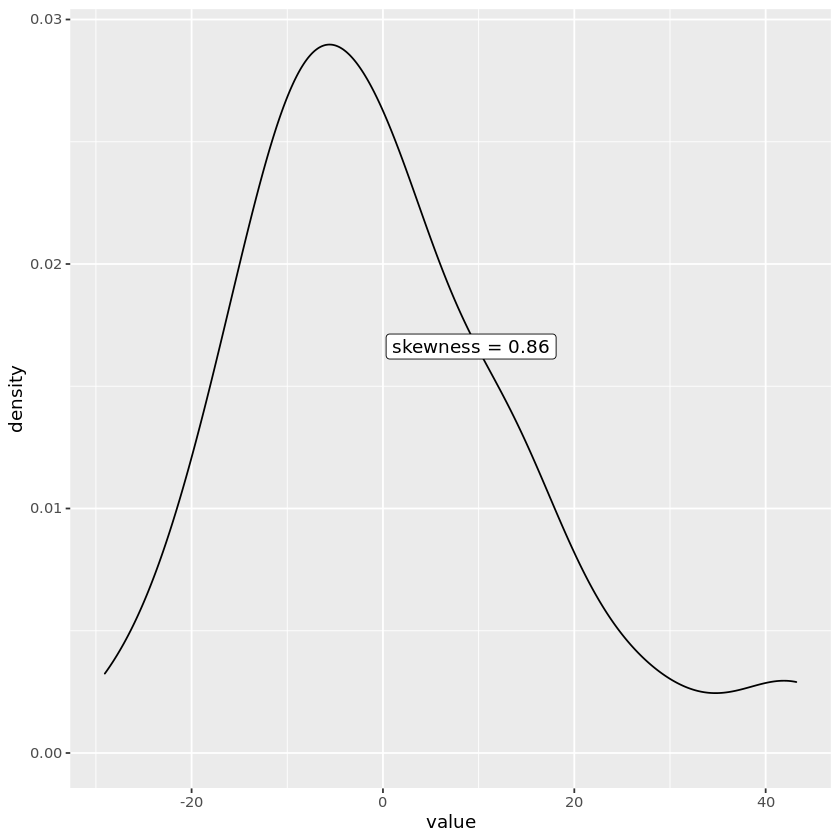

In [13]:
res <- model_residuals(lin_model, cars_df$dist, cars_df)
res$plt

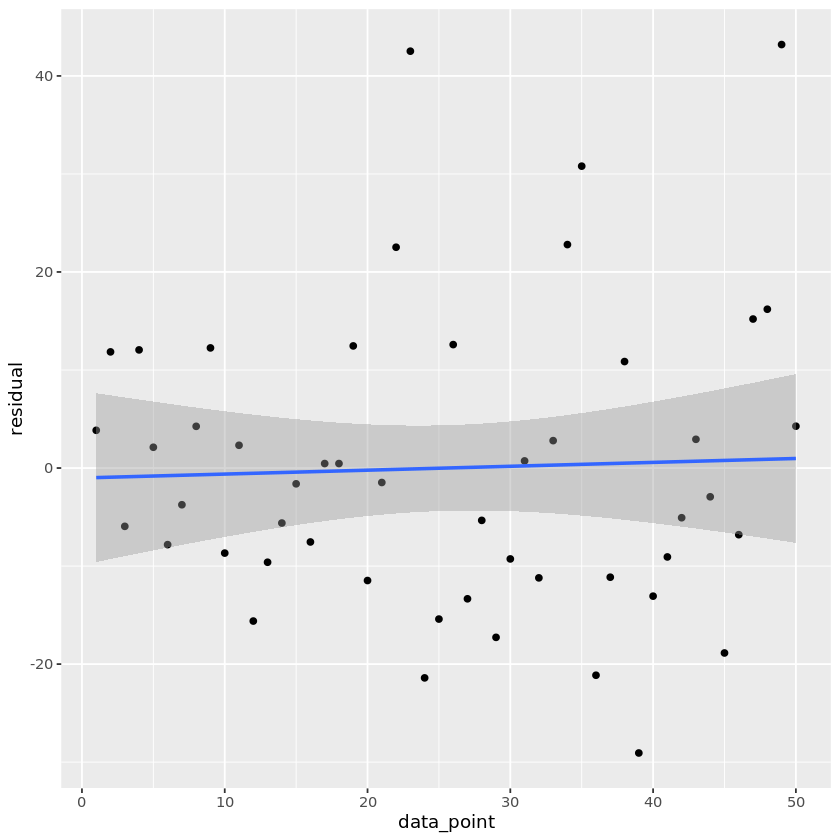

In [40]:
res_df <- tibble(data_point = seq_len(length(res$resid)), residual = res$resid)
ggplot(res_df) +
    aes(x = data_point, y = residual) +
    geom_point() +
    geom_smooth(method = "lm", formula = y ~ x)

## Prediction

In [14]:
set.seed(100)
train_idx <- sample(x = nrow(cars_df), size = round(.8 * nrow(cars_df), 1), replace = FALSE)
X_train <- cars_df[train_idx, ]
X_test <- cars_df[-train_idx, ]

In [15]:
lin_model <- glm(dist ~ speed, data = X_train, family = stats::gaussian(link = "identity"))

In [16]:
summary(lin_model)


Call:
glm(formula = dist ~ speed, family = stats::gaussian(link = "identity"), 
    data = X_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-24.726  -11.242   -2.564   10.436   40.565  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.1796     7.8254  -2.579   0.0139 *  
speed         4.2582     0.4947   8.608 1.85e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 240.0262)

    Null deviance: 26908  on 39  degrees of freedom
Residual deviance:  9121  on 38  degrees of freedom
AIC: 336.69

Number of Fisher Scoring iterations: 2


In [17]:
yhat <- predict.glm(lin_model, X_test)

In [18]:
lin_model_res <- eval_performance(X_test$dist, yhat)
lin_model_res

$cor_acc
[1] 0.9029504

$minmax_acc
[1] 0.7311131

$mse
[1] 267.0002

$mape
[1] 0.4959096

# K-fold CV

In [21]:
glm_k_fold_cv <- function(X, y_col, ..., k = 5) {
    folds <- createFolds(seq_len(nrow(X)), k = k, list = TRUE)
    res_ls <- list()
    for (i in seq_len(length(folds))) {
        model <- glm(data = X[-folds[[i]], ], ...)
        yhat <- predict.glm(model, X[folds[[i]], ])
        res_ls[[i]] <- eval_performance(y = as.matrix(X[folds[[i]], y_col]), yhat = yhat)
    }
    res_m <- matrix(unlist(res_ls), nrow = length(res_ls[[1]]))
    rownames(res_m) <- names(res_ls[[1]])
    t(res_m)
}

In [24]:
res_df <- glm_k_fold_cv(cars_df, 2, k = 5, formula = dist ~ speed, family = gaussian()) %>%
    as_tibble

In [25]:
res_df
summarize_all(res_df, mean)

cor_acc,minmax_acc,mse,mape
<dbl>,<dbl>,<dbl>,<dbl>
0.6635507,0.7379559,392.5180,0.2960502
0.9180722,0.7368888,115.9563,0.2684123
0.7654530,0.4594514,244.8280,0.6266398
0.9244021,0.7393633,150.1444,0.4336479
0.8006244,0.6824661,318.4037,0.5441553


cor_acc,minmax_acc,mse,mape
<dbl>,<dbl>,<dbl>,<dbl>
0.8144205,0.6712251,244.3701,0.4337811
